### Problem Description

The objective is to accurately **track a vehicle** as it moves along a two-dimensional plane. 🚗 The vehicle's motion is non-linear: it can execute coordinated turns, meaning its heading changes at a specific turn rate. Our only source of information is a sensor that provides **noisy measurements of the vehicle's x and y position** at discrete time intervals.

The core challenge is to estimate the vehicle's complete state, which includes not only its position but also its speed, heading, and current turn rate. Since the relationship between the state variables (especially heading and turn rate) and the resulting position is governed by non-linear trigonometric functions, a standard linear Kalman filter is inadequate. Therefore, we must use an **Extended Kalman Filter (EKF)**, which approximates the non-linear dynamics by linearizing the system around the current state estimate at each time step.

***

### EKF Formulation

#### State Vector

The state vector $x_k$ at time step $k$ fully describes the vehicle's dynamic state. It is defined as a 5-dimensional vector:

$x_k = \begin{bmatrix} p_{x,k} \\ p_{y,k} \\ v_k \\ \theta_k \\ \omega_k \end{bmatrix}$

-   $p_{x,k}, p_{y,k}$ are the vehicle's position coordinates.
-   $v_k$ is the vehicle's speed (magnitude of velocity).
-   $\theta_k$ is the vehicle's heading angle.
-   $\omega_k$ is the vehicle's turn rate (rate of change of heading).

*Suppose we only change the turn rate $\omega_k$ and vehicle's linear velocity $v_k$ is constant.*

---

#### State Transition Model

##### <ins> Goal and Assumptions </ins>

Our goal is to derive the function $f$ that predicts the state at time $k$ from the state at time $k-1$, as in $x_k = f(x_{k-1})$.

The derivation rests on a key assumption from physics: over a very small time interval, $\Delta t$, we assume the vehicle's **speed ($v$) and turn rate ($\omega$) are constant**. The heading ($\theta$) and position ($p_x, p_y$), however, will change based on these constant values.

##### <ins> Component-wise Derivation </ins>

We will derive the update equation for each of the five components of the state vector $x_k = [p_{x,k}, p_{y,k}, v_k, \theta_k, \omega_k]^T$.

###### <ins> 1. Speed ($v_k$) and Turn Rate ($\omega_k$) </ins>

These are the simplest components. Based on our core assumption that speed and turn rate are constant over the interval $\Delta t$, their predicted values are unchanged.

$v_k = v_{k-1}$ \\
$\omega_k = \omega_{k-1}$


###### <ins> 2. Heading ($\theta_k$) </ins>

The turn rate, $\omega$, is the rate of change of the heading angle, $\theta$. Assuming $\omega$ is constant over the interval, the change in heading is simply the rate multiplied by the time duration.

Change in Heading = Turn Rate $\times$ Time \\
$\Delta \theta = \omega_{k-1} \Delta t$

Therefore, the new heading is the old heading plus this change:

$\theta_k = \theta_{k-1} + \omega_{k-1} \Delta t$


###### <ins> 3. Position ($p_{x,k}$ and $p_{y,k}$) </ins>

This is the most involved part of the derivation as it requires calculus. The final position is the initial position plus the integral of the velocity over the time interval.

$p_{x,k} = p_{x,k-1} + \int_{t_{k-1}}^{t_k} v_x(t) dt$ \\
$p_{y,k} = p_{y,k-1} + \int_{t_{k-1}}^{t_k} v_y(t) dt$

The velocity components, $v_x(t)$ and $v_y(t)$, are not constant because the heading $\theta(t)$ is changing continuously throughout the interval. Let's define the time within the interval as $\tau$, where $\tau$ ranges from $0$ to $\Delta t$.

The heading at any time $\tau$ within the interval is:
$\theta(\tau) = \theta_{k-1} + \omega_{k-1} \tau$

The velocity components at time $\tau$ are then:
$v_x(\tau) = v_{k-1} \cos(\theta(\tau)) = v_{k-1} \cos(\theta_{k-1} + \omega_{k-1} \tau)$
$v_y(\tau) = v_{k-1} \sin(\theta(\tau)) = v_{k-1} \sin(\theta_{k-1} + \omega_{k-1} \tau)$

Now we can perform the integration with respect to $\tau$ from $0$ to $\Delta t$:

*  **For $p_x$:** \\
$\Delta p_x = \int_0^{\Delta t} v_{k-1} \cos(\theta_{k-1} + \omega_{k-1} \tau) d\tau$ \\
$\Delta p_x = v_{k-1} \left[ \frac{\sin(\theta_{k-1} + \omega_{k-1} \tau)}{\omega_{k-1}} \right]_0^{\Delta t}$ \\
$\Delta p_x = \frac{v_{k-1}}{\omega_{k-1}} \left[ \sin(\theta_{k-1} + \omega_{k-1} \Delta t) - \sin(\theta_{k-1} + 0) \right]$ \\
$\Delta p_x = \frac{v_{k-1}}{\omega_{k-1}} (\sin(\theta_{k-1} + \omega_{k-1} \Delta t) - \sin(\theta_{k-1}))$ \\
So, $p_{x,k} = p_{x,k-1} + \Delta p_x$.

* **For $p_y$:** \\
$\Delta p_y = \int_0^{\Delta t} v_{k-1} \sin(\theta_{k-1} + \omega_{k-1} \tau) d\tau$ \\
$\Delta p_y = v_{k-1} \left[ \frac{-\cos(\theta_{k-1} + \omega_{k-1} \tau)}{\omega_{k-1}} \right]_0^{\Delta t}$ \\
$\Delta p_y = \frac{v_{k-1}}{\omega_{k-1}} \left[ (-\cos(\theta_{k-1} + \omega_{k-1} \Delta t)) - (-\cos(\theta_{k-1} + 0)) \right]$ \\
$\Delta p_y = \frac{v_{k-1}}{\omega_{k-1}} (-\cos(\theta_{k-1} + \omega_{k-1} \Delta t) + \cos(\theta_{k-1}))$ \\
So, $p_{y,k} = p_{y,k-1} + \Delta p_y$.


Combining all the derived components gives us the complete state transition function $f(x_{k-1})$:

$f(x_{k-1}) = \begin{bmatrix}
p_{x, k-1} + \frac{v_{k-1}}{\omega_{k-1}} (\sin(\theta_{k-1} + \omega_{k-1}\Delta t) - \sin(\theta_{k-1})) \\
p_{y, k-1} + \frac{v_{k-1}}{\omega_{k-1}} (-\cos(\theta_{k-1} + \omega_{k-1}\Delta t) + \cos(\theta_{k-1})) \\
v_{k-1} \\
\theta_{k-1} + \omega_{k-1}\Delta t \\
\omega_{k-1}
\end{bmatrix}$


##### <ins> Special Case: Straight-Line Motion ($\omega \approx 0$) </ins>

The expressions for $p_x$ and $p_y$ involve division by $\omega_{k-1}$, which is undefined if the vehicle is moving straight ($\omega_{k-1} = 0$). In this case, the heading is constant: $\theta(t) = \theta_{k-1}$.

The velocity components are also constant: \\
$v_x = v_{k-1} \cos(\theta_{k-1})$ \\
$v_y = v_{k-1} \sin(\theta_{k-1})$

The integration becomes trivial: \\
$\Delta p_x = \int_0^{\Delta t} v_x d\tau = v_x \Delta t = v_{k-1} \cos(\theta_{k-1}) \Delta t$ \\
$\Delta p_y = \int_0^{\Delta t} v_y d\tau = v_y \Delta t = v_{k-1} \sin(\theta_{k-1}) \Delta t$

This gives the simplified update rule for straight-line motion.


For the special case where the turn rate $\omega \approx 0$ (to avoid division by zero), the model simplifies to straight-line motion:

$f(x_{k-1}) \bigg|_{\omega \approx 0} = \begin{bmatrix}
p_{x, k-1} + v_{k-1} \cos(\theta_{k-1}) \Delta t \\
p_{y, k-1} + v_{k-1} \sin(\theta_{k-1}) \Delta t \\
v_{k-1} \\
\theta_{k-1} \\
\omega_{k-1}
\end{bmatrix}$

---

The process noise $w_k \sim \mathcal{N}(0, Q)$ represents uncertainty in the model (e.g., unmodeled acceleration or changes in turn rate). The **process noise covariance matrix $Q$** is:

$Q = \text{diag}([0, 0, \sigma_v^2, 0, \sigma_\omega^2])$

-   $\sigma_v^2$: Variance representing noise in the vehicle's speed.
-   $\sigma_\omega^2$: Variance representing noise in the vehicle's turn rate.

---

#### Measurement Model

The measurement model relates the state vector $x_k$ to the measurement vector $z_k$. Since our sensor only measures position, the relationship is linear.

$z_k = H x_k + v_k$

-   $z_k = \begin{bmatrix} p_{x, \text{measured}} \\ p_{y, \text{measured}} \end{bmatrix}$ is the measurement vector.

-   $H = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \end{bmatrix}$ is the **measurement matrix**.

The measurement noise $v_k \sim \mathcal{N}(0, R)$ is assumed to be Gaussian with a **measurement noise covariance matrix $R$**:

$R = \begin{bmatrix} \sigma_p^2 & 0 \\ 0 & \sigma_p^2 \end{bmatrix}$

-   $\sigma_p^2$: Variance of the position sensor's measurement noise.

---

#### EKF Algorithm

The algorithm proceeds in two stages: Predict and Update.

**A. Predict Stage** 🔮

This stage predicts the next state and its uncertainty based on the model.

1.  **Project the state ahead:**
    $\hat{x}_{k}^{-}$
    
    $= f_{k-1}(\hat{x}_{k-1}^+,$ $ u(k-1), 0)$

2.  **Linearize and project the covariance ahead:**
    $P_{k}^- = F_{k-1} P_{k-1}^+ F_{k-1}^T + I Q_{k-1} I $

    -   $F_k$ is the **Jacobian of the state transition function $f$** with respect to the state, evaluated at the previous state estimate $\hat{x}_{k-1}^+$:

        $F_k = \frac{\partial f_{k-1}}{\partial x} \bigg|_{\hat{x}^+(k-1)}$

    - $L_{k-1} = I$ since the noise is additive.
        
**B. Update Stage** ✅

- For our problem, the measurement function $h_k$ relates the state to the measured position. The general form is $y_k = h_k(x_k, v_k)$. In our specific case with additive noise, the function can be written as:

$h_k(x_k, v_k) = \underbrace{\begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \end{bmatrix} x_k}_{h_{\text{model}}(x_k)} + v_k$

1.  **Compute $H_k = \frac{\partial h_k}{\partial x} \bigg|_{\hat{x}_k^-}$**:
    This is the Jacobian of the measurement function with respect to the state. Since our measurement function is linear with respect to the state (it just selects the first two elements), the Jacobian is a constant matrix:

    $H_k =$
    
    \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \end{bmatrix}

2.  **Compute $M_k = \frac{\partial h_k}{\partial v} \bigg|_{\hat{x}_k^-}$**:
    This is the Jacobian of the measurement function with respect to the measurement noise `v`. Following the same logic as for the process noise, we differentiate the entire expression:

    $M_k = \frac{\partial}{\partial v_k} \left( h_{\text{model}}(x_k) + v_k \right) = \frac{\partial h_{\text{model}}(x_k)}{\partial v_k} + \frac{\partial v_k}{\partial v_k}$

    The first term is zero, and the second term is the identity matrix. Therefore, for our additive noise model:

    $M_k = I =$
    
    \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}

- Perform the measurement update of the state estimate and estimation-error covariance:

With the Jacobians $H_k$ and $M_k=I$ determined, the general update equations from your document simplify to their more common forms.

1.  **Compute the Kalman Gain $K_k$**:
    The general formula is $K_k = P_k^- H_k^T (H_k P_k^- H_k^T + M_k R_k M_k^T)^{-1}$.  
    
    Substituting $M_k = I$:

    $K_k = P_k^- H_k^T (H_k P_k^- H_k^T + I R_k I^T)^{-1}$

    $K_k = P_k^- H_k^T (H_k P_k^- H_k^T + R_k)^{-1}$

2.  **Update the state estimate $\hat{x}_k^+$**:
    The general formula is $\hat{x}_k^+ = \hat{x}_k^- + K_k [y_k - h_k(\hat{x}_k^-, 0)]$.

    For our model, $h_k(\hat{x}_k^-, 0) = H_k \hat{x}_k^-$. This gives the standard update equation:

    $\hat{x}_k^+ = \hat{x}_k^- + K_k (y_k - H_k \hat{x}_k^-)$

3.  **Update the error covariance $P_k^+$**:
    This equation does not depend on `M`, so it remains in its standard form:

    $P_k^+ = (I - K_k H_k) P_k^-$

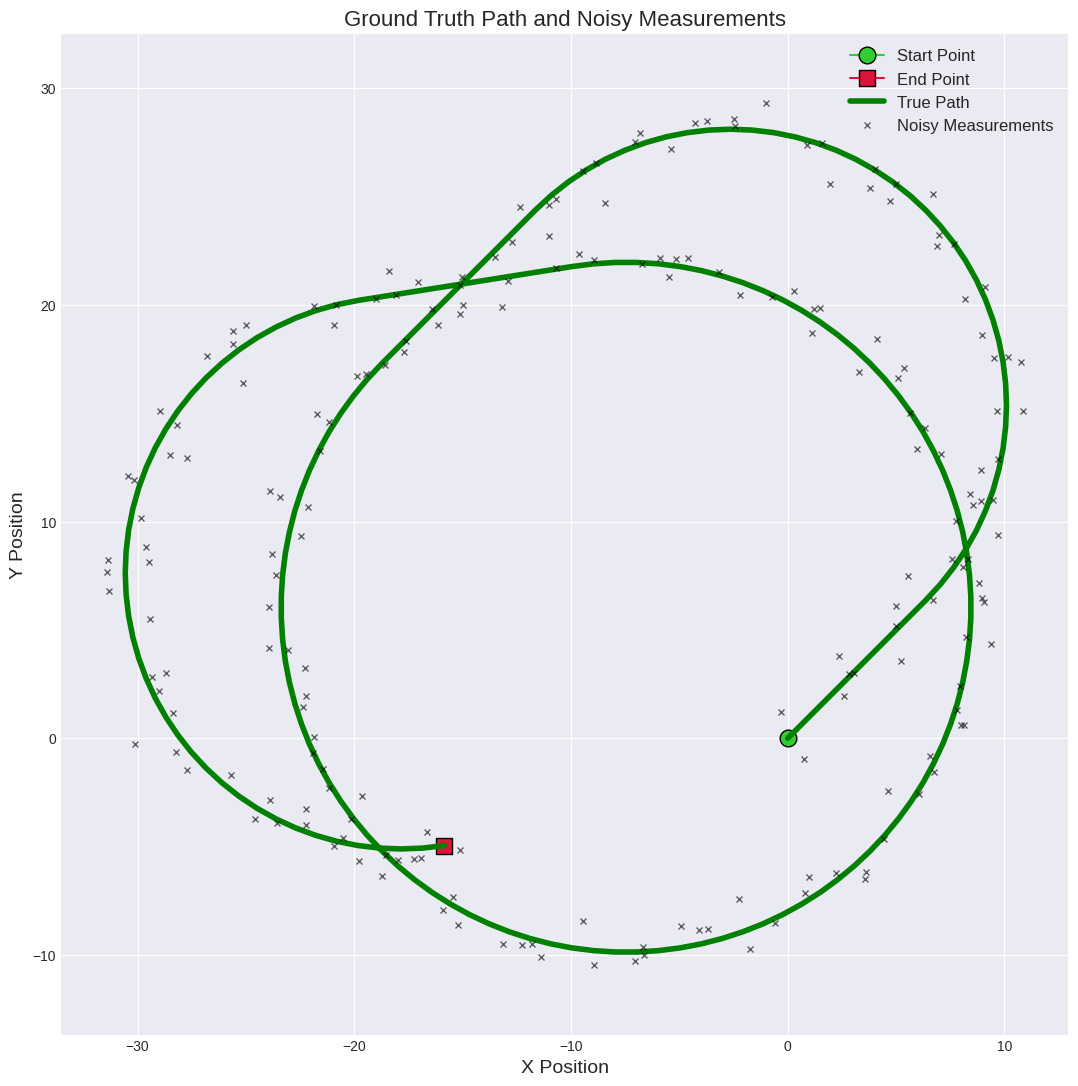

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Setup Simulation ---
dt = 0.1
num_steps = 200
v = 10.0 # True speed # 10
state_dim = 5 # STATE: [px, py, v, theta, omega]

# --- 2. Generate True Trajectory (using the same Coordinated Turn logic) ---
true_states = np.zeros((num_steps, state_dim, 1))
true_states[0] = np.array([[0], [0], [v], [np.pi/4], [0]]) # Start at origin, 45 deg heading

# Define the turn rates for the true path
for k in range(1, num_steps):
    omega_true = 0
    if 1 <= k * dt < 5:
        omega_true = np.pi / 4  # Gentle right turn
    elif 6 <= k * dt < 11:
        omega_true = np.pi / 5 # Sharper left turn
    elif 11 <= k * dt < 15:
        omega_true = np.pi / 5 # Sharper right turn
    elif 16 <= k * dt < 20:
        omega_true = np.pi / 4 # Sharper left turn

    # Propagate true state using the non-linear model
    px,py,v_true,theta,_ = true_states[k-1].flatten()

    theta_new = theta + omega_true * dt

    if abs(omega_true) > 1e-6:
        px_new = px + (v_true/omega_true)*(np.sin(theta_new) - np.sin(theta))
        py_new = py + (v_true/omega_true)*(-np.cos(theta_new) + np.cos(theta))
    else:
        px_new = px + v_true*np.cos(theta)*dt
        py_new = py + v_true*np.sin(theta)*dt

    true_states[k] = np.array([[px_new], [py_new], [v_true], [theta_new], [omega_true]])

# --- 3. Generate Noisy Measurements ---
measurement_dim = 2
r_std = 0.7 #0.7
R = np.eye(measurement_dim) * r_std**2
measurements = np.zeros((num_steps, measurement_dim, 1))
H_sensor = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]]) # Sensor matrix for the new 5D state
for k in range(num_steps):
    noise = np.random.multivariate_normal(np.zeros(measurement_dim), R).reshape(measurement_dim, 1)
    measurements[k] = H_sensor @ true_states[k] + noise

# Process Noise: uncertainty in how speed and turn-rate might change
# We assume unmodeled accelerations (affecting v) and changes in turn-rate.
v_noise_std = 2.0  # m/s per second #2.0
omega_noise_std = np.deg2rad(10) # rad/s per second #10
Q = np.diag([0.0, 0.0, (v_noise_std*dt)**2, 0.0, (omega_noise_std*dt)**2])

# --- Visualization ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(13, 13))

# --- Plot Trajectories ---
# Get the start point coordinates from the true_states array
start_point_x = true_states[0, 0, 0]
start_point_y = true_states[0, 1, 0]

# Get the end point coordinates
end_point_x = true_states[-1, 0, 0]
end_point_y = true_states[-1, 1, 0]

# Plot the Start Point (a large green circle)
ax.plot(start_point_x, start_point_y,
        marker='o',
        markersize=12,
        color='limegreen',
        markeredgecolor='black', # Add a black edge for visibility
        label='Start Point')

# Plot the End Point (a large red square)
ax.plot(end_point_x, end_point_y,
        marker='s', # 's' for square
        markersize=12,
        color='crimson',
        markeredgecolor='black',
        label='End Point')

ax.plot(true_states[:, 0], true_states[:, 1], 'g-', linewidth=4, label='True Path')
ax.plot(measurements[:, 0], measurements[:, 1], 'kx', markersize=5, alpha=0.6, label='Noisy Measurements')

ax.set_title('Ground Truth Path and Noisy Measurements', fontsize=16)
ax.set_xlabel('X Position', fontsize=14)
ax.set_ylabel('Y Position', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
ax.axis('equal')

plt.show()

In [ ]:
# =============================================================================
# --- FILTER STEP FUNCTIONS ---
# =============================================================================

def lkf_step_joseph_form(x_hat_prev, P_prev, measurement, F, H, Q, R):
    """
    Performs a single LKF step using the exact form from the provided document,
    including the Joseph stabilized covariance update.
    """
    I = np.eye(F.shape[0]) # Identity matrix

    # --- 1. A Priori (Propagate) ---

    # (5.17) Predict the state estimate (a priori)
    # Note: No control input u, so the G*u term is zero.
    x_hat_minus = F @ x_hat_prev

    # Predict the error covariance (a priori)
    P_minus = F @ P_prev @ F.T + Q

    # --- 2. A Posteriori (Update) ---

    # Compute Kalman Gain
    # K_k = P_k^- H_k^T (H_k P_k^- H_k^T + R_k)^-1
    innovation_covariance = H @ P_minus @ H.T + R
    K = P_minus @ H.T @ np.linalg.inv(innovation_covariance)

    # (5.19) Update the state estimate (a posteriori)
    # x_k^+ = x_k^- + K_k(y_k - H_k * x_k^-)
    innovation = measurement - H @ x_hat_minus
    x_hat_plus = x_hat_minus + K @ innovation

    # (5.19) Update the error covariance using the Joseph stabilized form (a posteriori)
    # P_k^+ = (I - K_k*H_k) * P_k^- * (I - K_k*H_k)^T + K_k*R_k*K_k^T
    I_minus_KH = I - K @ H
    P_plus = I_minus_KH @ P_minus @ I_minus_KH.T + K @ R @ K.T

    return x_hat_plus, P_plus

def ekf_step_nonlinear(x_hat_prev, P_prev, measurement, dt, Q, R):
    """
    Performs a single EKF predict and update step using a non-linear
    Coordinated Turn (CT) model.

    Args:
        x_hat_prev (numpy.ndarray): Previous state estimate (shape [5, 1]).
        P_prev (numpy.ndarray): Previous covariance matrix (shape [5, 5]).
        measurement (numpy.ndarray): Current measurement (shape [2, 1]).
        dt (float): Time step.
        Q (numpy.ndarray): Process noise covariance matrix (shape [5, 5]).
        R (numpy.ndarray): Measurement noise covariance matrix (shape [2, 2]).

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: The updated state estimate (x_hat_plus).
            - numpy.ndarray: The updated covariance matrix (P_plus).
    """
    state_dim = 5

    # --- 1. Propagate ---

    # Extract previous state variables for clarity
    px_prev, py_prev, v_prev, theta_prev, omega_prev = x_hat_prev.flatten()

    # a. Define the non-linear state transition function f(x)
    def f(x):
        px, py, v, theta, omega = x.flatten()

        # Avoid division by zero for straight motion
        if np.abs(omega) < 1e-6:
            px_new = px + v * np.cos(theta) * dt
            py_new = py + v * np.sin(theta) * dt
        else:
            px_new = px + (v / omega) * (np.sin(theta + omega * dt) - np.sin(theta))
            py_new = py + (v / omega) * (-np.cos(theta + omega * dt) + np.cos(theta))

        v_new = v
        theta_new = theta + omega * dt
        omega_new = omega

        return np.array([[px_new], [py_new], [v_new], [theta_new], [omega_new]])

    # b. Project state ahead using the non-linear function
    x_hat_minus = f(x_hat_prev)

    # c. Calculate the Jacobian of the state transition function, F
    #    This matrix linearizes the non-linear model around the previous state
    F = np.zeros((state_dim, state_dim))

    # Pre-calculate trig terms for efficiency
    sin_theta = np.sin(theta_prev)
    cos_theta = np.cos(theta_prev)
    sin_theta_dt = np.sin(theta_prev + omega_prev * dt)
    cos_theta_dt = np.cos(theta_prev + omega_prev * dt)

    if np.abs(omega_prev) < 1e-6: # Handle straight-line case
        F[0, 2] = cos_theta * dt
        F[0, 3] = -v_prev * sin_theta * dt
        F[1, 2] = sin_theta * dt
        F[1, 3] = v_prev * cos_theta * dt
    else:
        v_over_omega = v_prev / omega_prev
        F[0, 2] = (sin_theta_dt - sin_theta) / omega_prev
        F[0, 3] = v_over_omega * (cos_theta_dt - cos_theta)
        F[0, 4] = -v_over_omega/omega_prev * (sin_theta_dt - sin_theta) + v_over_omega * cos_theta_dt * dt
        F[1, 2] = (-cos_theta_dt + cos_theta) / omega_prev
        F[1, 3] = v_over_omega * (sin_theta_dt - sin_theta)
        F[1, 4] = -v_over_omega/omega_prev * (-cos_theta_dt + cos_theta) + v_over_omega * sin_theta_dt * dt

    # Common terms for all cases
    F[0, 0] = 1.0
    F[1, 1] = 1.0
    F[2, 2] = 1.0
    F[3, 3] = 1.0
    F[3, 4] = dt
    F[4, 4] = 1.0

    # d. Project covariance ahead
    P_minus = F @ P_prev @ F.T + Q

    # --- 2. Update (Measurement Update) ---

    # a. Define the measurement function h(x) and its Jacobian H
    #    The sensor measures position (px, py), which is a linear mapping.
    def h(x):
        return x[:2] # Extracts [px, py]

    # Jacobian H is constant because the measurement function is linear
    H = np.array([[1, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0]])

    # b. Calculate Kalman Gain
    innovation_covariance = H @ P_minus @ H.T + R
    K = P_minus @ H.T @ np.linalg.inv(innovation_covariance)

    # c. Update estimate with measurement
    innovation = measurement - h(x_hat_minus)
    x_hat_plus = x_hat_minus + K @ innovation

    # d. Update covariance
    P_plus = (np.eye(state_dim) - K @ H) @ P_minus

    return x_hat_plus, P_plus



In [ ]:
# =============================================================================
# --- MAIN SCRIPT ---
# =============================================================================

# --- 4. EKF Initialization ---
# Initial state guess: Let's assume we know the initial position but are unsure about heading.
x_hat_initial = np.array([[0], [0], [v + (np.random.rand()-0.5) * v/10], [np.pi/10], [0.0]])
# Initial covariance: High uncertainty in velocity, heading, and turn rate. # 2.0 20, 10
P_initial = np.diag([1.0, 1.0, 2.0, np.deg2rad(20)**2, np.deg2rad(10)**2])

# EKF Variables
ekf_estimates = np.zeros((num_steps, state_dim, 1))
ekf_estimates[0] = x_hat_initial

ekf_P_history = np.zeros((num_steps, state_dim, state_dim))
ekf_P_history[0] = P_initial

P_ekf = P_initial.copy()

# Linear KF Variables
lkf_estimates = np.zeros((num_steps, state_dim, 1))
lkf_estimates[0] = x_hat_initial

lkf_P_history = np.zeros((num_steps, state_dim, state_dim))
lkf_P_history[0] = P_initial
P_lkf = P_initial.copy()

F_lkf = np.eye(state_dim)
v_init, theta_init = x_hat_initial[2,0], x_hat_initial[3,0]
F_lkf[0,2], F_lkf[0,3] = np.cos(theta_init)*dt, -v_init*np.sin(theta_init)*dt
F_lkf[1,2], F_lkf[1,3] = np.sin(theta_init)*dt, v_init*np.cos(theta_init)*dt
F_lkf[3,4] = dt

H_lkf = np.array([[1,0,0,0,0],[0,1,0,0,0]])

# --- 5. Run Both Filters ---
for k in range(1, num_steps):
    # EKF Step
    x_hat_ekf, P_ekf = ekf_step_nonlinear(ekf_estimates[k-1], P_ekf, measurements[k], dt, Q, R)
    ekf_estimates[k] = x_hat_ekf
    ekf_P_history[k] = P_ekf

    # LKF Step (NOW CALLING THE NEW FUNCTION)
    x_hat_lkf, P_lkf = lkf_step_joseph_form(lkf_estimates[k-1], P_lkf, measurements[k], F_lkf, H_lkf, Q, R)
    lkf_estimates[k] = x_hat_lkf
    lkf_P_history[k] = P_lkf

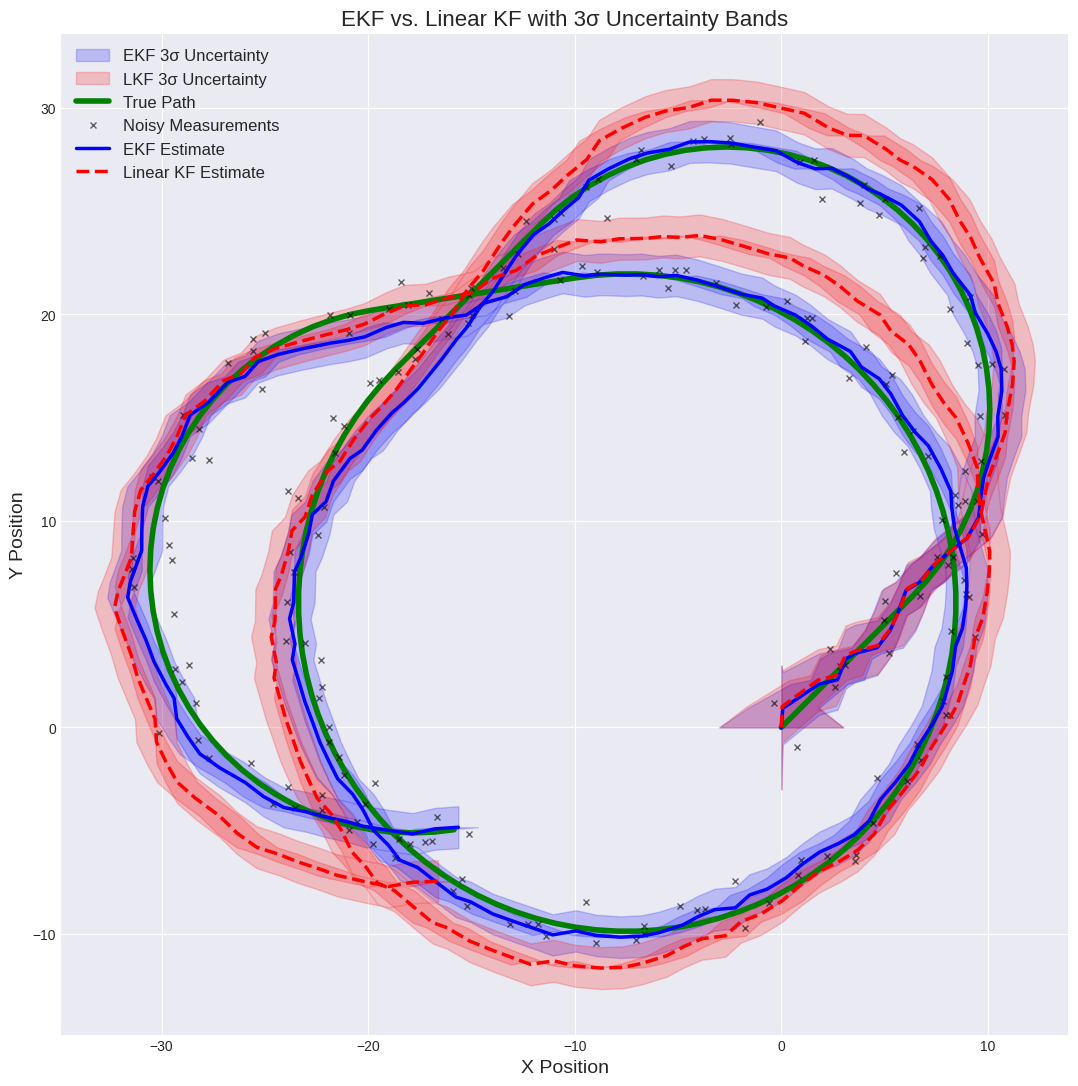

In [ ]:
# --- 6. Visualization ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(13, 13))

# Extract position uncertainty (3-sigma bounds)
ekf_px_std = np.sqrt(ekf_P_history[:, 0, 0])
ekf_py_std = np.sqrt(ekf_P_history[:, 1, 1])
ekf_lower_bound_x = ekf_estimates[:, 0, 0] - 3 * ekf_px_std
ekf_upper_bound_x = ekf_estimates[:, 0, 0] + 3 * ekf_px_std
ekf_lower_bound_y = ekf_estimates[:, 1, 0] - 3 * ekf_py_std
ekf_upper_bound_y = ekf_estimates[:, 1, 0] + 3 * ekf_py_std

lkf_px_std = np.sqrt(lkf_P_history[:, 0, 0])
lkf_py_std = np.sqrt(lkf_P_history[:, 1, 1])
lkf_lower_bound_x = lkf_estimates[:, 0, 0] - 3 * lkf_px_std
lkf_upper_bound_x = lkf_estimates[:, 0, 0] + 3 * lkf_px_std
lkf_lower_bound_y = lkf_estimates[:, 1, 0] - 3 * lkf_py_std
lkf_upper_bound_y = lkf_estimates[:, 1, 0] + 3 * lkf_py_std

# --- Plot Y-Axis Uncertainty (Vertical Fill) ---
# Use fill_between with the X-positions as the base axis
ax.fill_between(
    ekf_estimates[:, 0, 0],
    ekf_lower_bound_y,
    ekf_upper_bound_y,
    color='blue',
    alpha=0.2,
    label='EKF 3σ Uncertainty'
)
ax.fill_between(
    lkf_estimates[:, 0, 0],
    lkf_lower_bound_y,
    lkf_upper_bound_y,
    color='red',
    alpha=0.2,
    label='LKF 3σ Uncertainty'
)

# --- Plot X-Axis Uncertainty (Horizontal Fill) ---
# Use fill_betweenx with the Y-positions as the base axis
ax.fill_betweenx(
    ekf_estimates[:, 1, 0],
    ekf_lower_bound_x,
    ekf_upper_bound_x,
    color='blue',
    alpha=0.2
)
ax.fill_betweenx(
    lkf_estimates[:, 1, 0],
    lkf_lower_bound_x,
    lkf_upper_bound_x,
    color='red',
    alpha=0.2
)

# --- Plot Trajectories ---
ax.plot(true_states[:, 0], true_states[:, 1], 'g-', linewidth=4, label='True Path')
ax.plot(measurements[:, 0], measurements[:, 1], 'kx', markersize=5, alpha=0.6, label='Noisy Measurements')
ax.plot(ekf_estimates[:, 0], ekf_estimates[:, 1], 'b-', linewidth=2.5, label='EKF Estimate')
ax.plot(lkf_estimates[:, 0], lkf_estimates[:, 1], 'r--', linewidth=2.5, label='Linear KF Estimate')

ax.set_title('EKF vs. Linear KF with 3σ Uncertainty Bands', fontsize=16)
ax.set_xlabel('X Position', fontsize=14)
ax.set_ylabel('Y Position', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
ax.axis('equal')

plt.show()


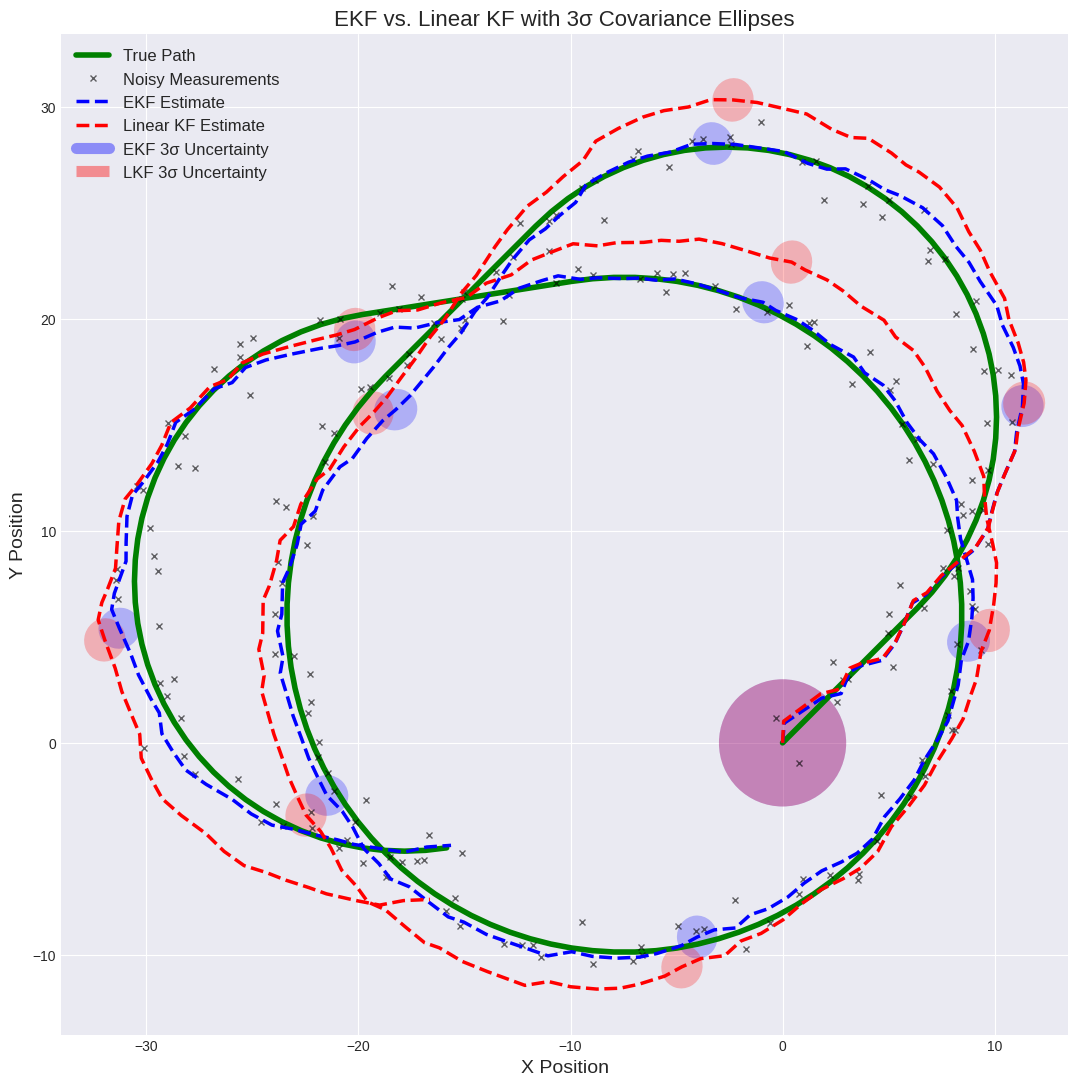

In [ ]:
from matplotlib.patches import Ellipse

# =============================================================================
# --- HELPER FUNCTION FOR PLOTTING ---
# =============================================================================
def plot_covariance_ellipse(mean, cov, ax, n_std=3.0, **kwargs):
    """
    Plots a 2D covariance ellipse on the given axes.

    Args:
        mean (numpy.ndarray): The 2D mean vector (center of the ellipse).
        cov (numpy.ndarray): The 2x2 covariance matrix.
        ax (matplotlib.axes.Axes): The axes to plot on.
        n_std (float): The number of standard deviations to plot (e.g., 3 for 3-sigma).
        **kwargs: Additional arguments passed to the Ellipse patch.
    """
    # Ensure covariance matrix is 2x2
    cov = cov[:2, :2]

    # Eigenvalue decomposition
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Get the angle of the largest eigenvector
    angle = np.degrees(np.arctan2(*eigenvecs[:, 1]))

    # Get the ellipse width and height (scaled by n_std)
    # The eigenvalues are the variances, so we take the sqrt for std dev
    width, height = 2 * n_std * np.sqrt(eigenvals)

    # Create the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)

    ax.add_patch(ellipse)


# =============================================================================
# --- 6. VISUALIZATION WITH UNCERTAINTY ELLIPSES ---
# =============================================================================
plt.style.use('seaborn-v0_8-darkgrid')
# Create a figure and axes object, which is needed for adding patches
fig, ax = plt.subplots(figsize=(13, 13))

# Plot the main trajectories
ax.plot(true_states[:, 0], true_states[:, 1], 'g-', linewidth=4, label='True Path')
ax.plot(measurements[:, 0], measurements[:, 1], 'kx', markersize=5, alpha=0.6, label='Noisy Measurements')
ax.plot(ekf_estimates[:, 0], ekf_estimates[:, 1], 'b--', linewidth=2.5, label='EKF Estimate')
ax.plot(lkf_estimates[:, 0], lkf_estimates[:, 1], 'r--', linewidth=2.5, label='Linear KF Estimate')

# Plot the uncertainty ellipses at regular intervals to avoid clutter
for k in range(0, num_steps, 20):
    # EKF Ellipse
    plot_covariance_ellipse(
        ekf_estimates[k, :2].flatten(),
        ekf_P_history[k],
        ax,
        facecolor='blue',
        alpha=0.25
    )
    # LKF Ellipse
    plot_covariance_ellipse(
        lkf_estimates[k, :2].flatten(),
        lkf_P_history[k],
        ax,
        facecolor='red',
        alpha=0.25,
        linestyle='--'
    )

# Create dummy plots for the legend to represent the ellipses
ax.plot([], [], 'b-', alpha=0.4, linewidth=8, label='EKF 3σ Uncertainty')
ax.plot([], [], 'r--', alpha=0.4, linewidth=8, label='LKF 3σ Uncertainty')


ax.set_title('EKF vs. Linear KF with 3σ Covariance Ellipses', fontsize=16)
ax.set_xlabel('X Position', fontsize=14)
ax.set_ylabel('Y Position', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
ax.axis('equal')

plt.show()


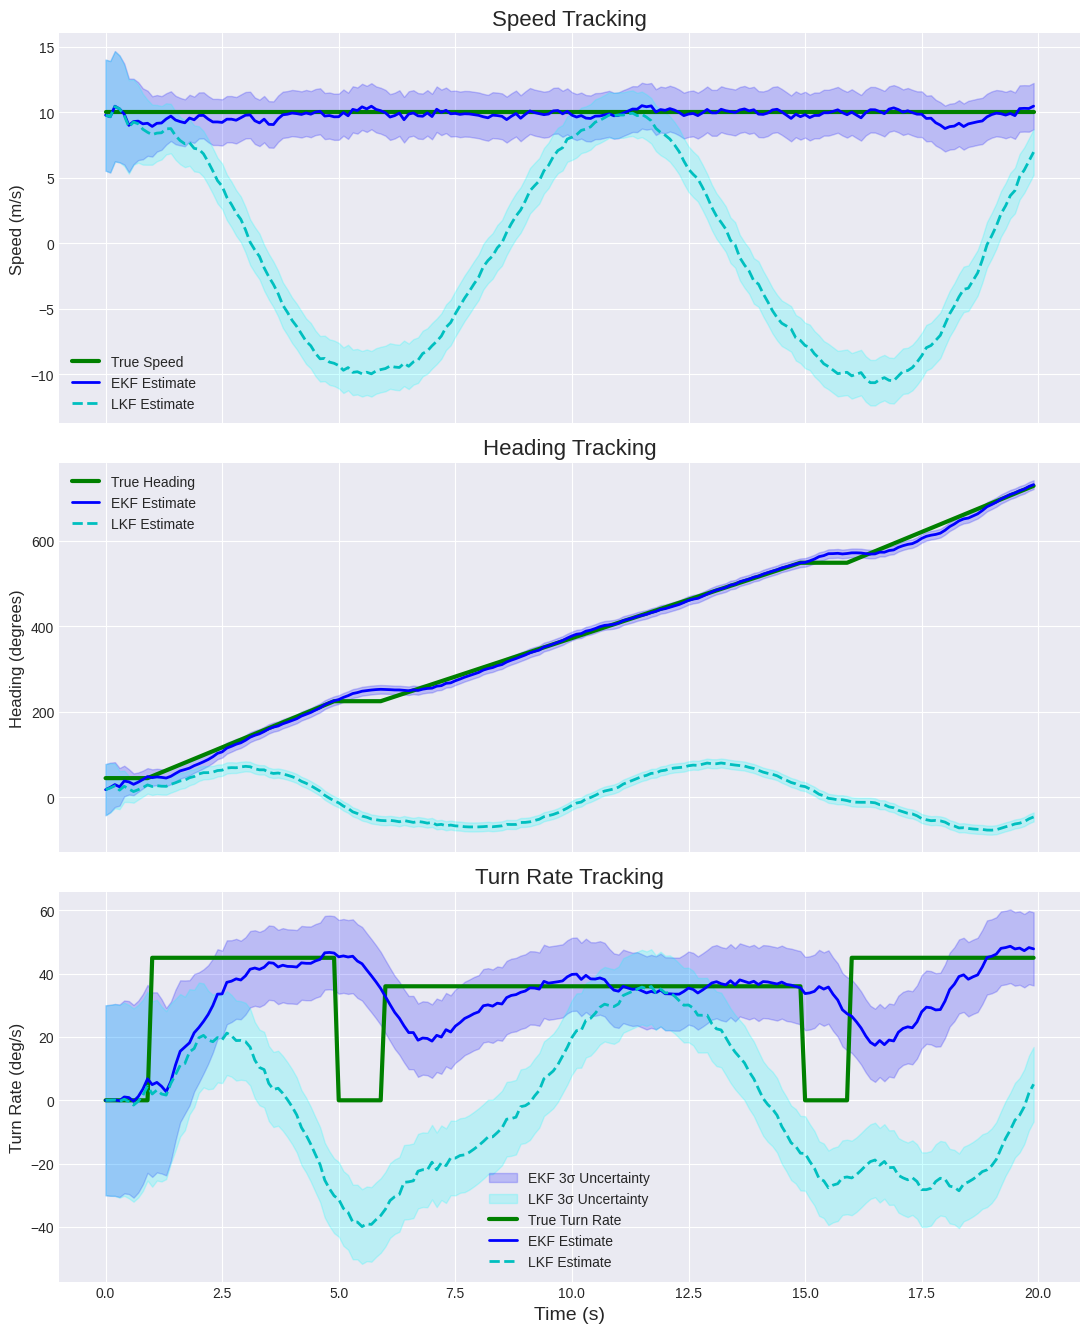

In [ ]:
# =============================================================================
# --- 7. VISUALIZATION OF OTHER STATES (v, theta, omega) ---
# =============================================================================

# Create a time axis for the plots
time_axis = np.arange(num_steps) * dt

# Create a figure with 3 subplots, sharing the x-axis
fig, axes = plt.subplots(3, 1, figsize=(11, 14), sharex=True)
#fig.suptitle('Filter Performance on Individual States', fontsize=20, y=0.93)


# --- Plot 1: Speed (v) ---
ax1 = axes[0]
# EKF uncertainty
ekf_v_std = np.sqrt(ekf_P_history[:, 2, 2])
ax1.fill_between(time_axis, ekf_estimates[:, 2, 0] - 3 * ekf_v_std, ekf_estimates[:, 2, 0] + 3 * ekf_v_std, color='blue', alpha=0.2)
# LTV KF uncertainty
lkf_v_std = np.sqrt(lkf_P_history[:, 2, 2])
ax1.fill_between(time_axis, lkf_estimates[:, 2, 0] - 3 * lkf_v_std, lkf_estimates[:, 2, 0] + 3 * lkf_v_std, color='cyan', alpha=0.2)
# Estimates and True Value
ax1.plot(time_axis, true_states[:, 2, 0], 'g-', linewidth=3, label='True Speed')
ax1.plot(time_axis, ekf_estimates[:, 2, 0], 'b-', linewidth=2, label='EKF Estimate')
ax1.plot(time_axis, lkf_estimates[:, 2, 0], 'c--', linewidth=2, label='LKF Estimate')
ax1.set_title('Speed Tracking', fontsize=16)
ax1.set_ylabel('Speed (m/s)', fontsize=12)
ax1.legend()
ax1.grid(True)


# --- Plot 2: Heading (theta) ---
ax2 = axes[1]
# Convert radians to degrees for plotting
true_heading_deg = np.degrees(true_states[:, 3, 0])
ekf_heading_deg = np.degrees(ekf_estimates[:, 3, 0])
lkf_heading_deg = np.degrees(lkf_estimates[:, 3, 0])
# EKF uncertainty
ekf_theta_std_deg = np.degrees(np.sqrt(ekf_P_history[:, 3, 3]))
ax2.fill_between(time_axis, ekf_heading_deg - 3 * ekf_theta_std_deg, ekf_heading_deg + 3 * ekf_theta_std_deg, color='blue', alpha=0.2)
# LTV KF uncertainty
lkf_theta_std_deg = np.degrees(np.sqrt(lkf_P_history[:, 3, 3]))
ax2.fill_between(time_axis, lkf_heading_deg - 3 * lkf_theta_std_deg, lkf_heading_deg + 3 * lkf_theta_std_deg, color='cyan', alpha=0.2)
# Estimates and True Value
ax2.plot(time_axis, true_heading_deg, 'g-', linewidth=3, label='True Heading')
ax2.plot(time_axis, ekf_heading_deg, 'b-', linewidth=2, label='EKF Estimate')
ax2.plot(time_axis, lkf_heading_deg, 'c--', linewidth=2, label='LKF Estimate')
ax2.set_title('Heading Tracking', fontsize=16)
ax2.set_ylabel('Heading (degrees)', fontsize=12)
ax2.legend()
ax2.grid(True)


# --- Plot 3: Turn Rate (omega) ---
ax3 = axes[2]
# Convert rad/s to deg/s for plotting
true_omega_dps = np.degrees(true_states[:, 4, 0])
ekf_omega_dps = np.degrees(ekf_estimates[:, 4, 0])
lkf_omega_dps = np.degrees(lkf_estimates[:, 4, 0])
# EKF uncertainty
ekf_omega_std_dps = np.degrees(np.sqrt(ekf_P_history[:, 4, 4]))
ax3.fill_between(time_axis, ekf_omega_dps - 3 * ekf_omega_std_dps, ekf_omega_dps + 3 * ekf_omega_std_dps, color='blue', alpha=0.2, label='EKF 3σ Uncertainty')
# LTV KF uncertainty
lkf_omega_std_dps = np.degrees(np.sqrt(lkf_P_history[:, 4, 4]))
ax3.fill_between(time_axis, lkf_omega_dps - 3 * lkf_omega_std_dps, lkf_omega_dps + 3 * lkf_omega_std_dps, color='cyan', alpha=0.2, label='LKF 3σ Uncertainty')
# Estimates and True Value
ax3.plot(time_axis, true_omega_dps, 'g-', linewidth=3, label='True Turn Rate')
ax3.plot(time_axis, ekf_omega_dps, 'b-', linewidth=2, label='EKF Estimate')
ax3.plot(time_axis, lkf_omega_dps, 'c--', linewidth=2, label='LKF Estimate')
ax3.set_title('Turn Rate Tracking', fontsize=16)
ax3.set_xlabel('Time (s)', fontsize=14)
ax3.set_ylabel('Turn Rate (deg/s)', fontsize=12)
ax3.legend()
ax3.grid(True)


# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

EKF Position RMSE: 0.6012 meters
LKF Position RMSE: 1.7367 meters


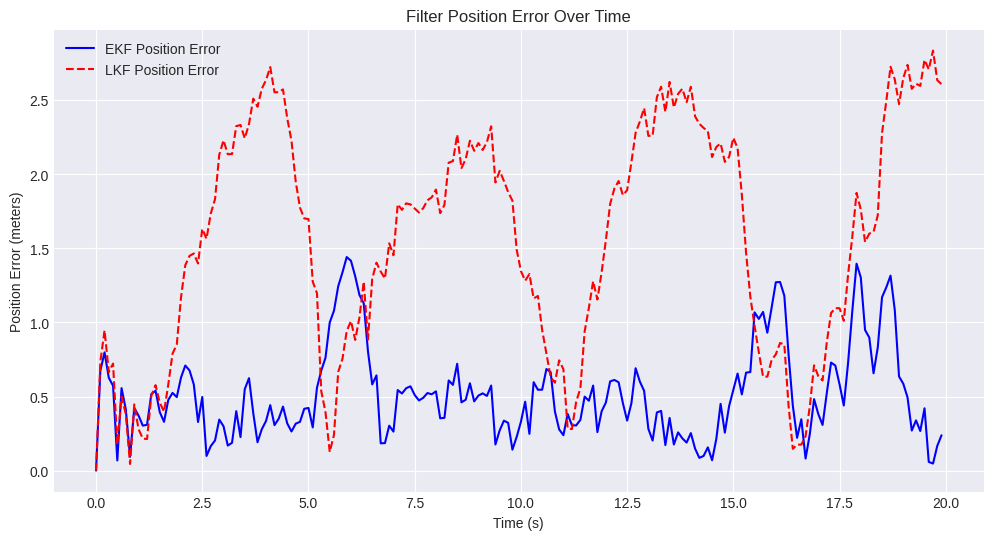

In [ ]:
# --- 6. Performance Quantification ---

# Calculate the error vectors at each time step
ekf_errors = true_states[:, :2] - ekf_estimates[:, :2]
lkf_errors = true_states[:, :2] - lkf_estimates[:, :2]

# Calculate the squared errors
ekf_squared_errors = np.sum(ekf_errors**2, axis=1)
lkf_squared_errors = np.sum(lkf_errors**2, axis=1)

# Calculate the Root Mean Squared Error (RMSE)
ekf_rmse = np.sqrt(np.mean(ekf_squared_errors))
lkf_rmse = np.sqrt(np.mean(lkf_squared_errors))

print(f"EKF Position RMSE: {ekf_rmse:.4f} meters")
print(f"LKF Position RMSE: {lkf_rmse:.4f} meters")

# We can also plot the error over time
time_axis = np.arange(num_steps) * dt
plt.figure(figsize=(12, 6))
plt.plot(time_axis, np.sqrt(ekf_squared_errors), 'b-', label='EKF Position Error')
plt.plot(time_axis, np.sqrt(lkf_squared_errors), 'r--', label='LKF Position Error')
plt.title('Filter Position Error Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Position Error (meters)')
plt.legend()
plt.grid(True)
# This will be shown before the trajectory plot
plt.show()

### Rationale for the LKF's Constant F Matrix

The constant `F_lkf` is the **Jacobian** of the non-linear motion model, $\frac{\partial f}{\partial x}$, evaluated only once at the initial state estimate $\hat{x}_{init}$ (assuming an initial turn rate $\omega_{init}=0$). This creates a fixed, linear "Constant Velocity" model.

---

**1. Simplified Non-Linear Model (for $\omega=0$):**

This is the function we linearize.

$x_k = f(x_{k-1}) = \begin{bmatrix}
p_x + v \cos(\theta) \Delta t \\
p_y + v \sin(\theta) \Delta t \\
v \\
\theta + \omega\Delta t \\
\omega
\end{bmatrix}$

---

**2. Compute Jacobian $F(x) = \frac{\partial f}{\partial x}$ evaluated at $\hat{x}_{init}$:**

We find the partial derivative of each component of $f(x)$ with respect to each state variable.

* $\frac{\partial f_1}{\partial v} = \cos(\theta_{init})\Delta t$
* $\frac{\partial f_1}{\partial \theta} = -v_{init}\sin(\theta_{init})\Delta t$
* $\frac{\partial f_2}{\partial v} = \sin(\theta_{init})\Delta t$
* $\partial f_2 / \partial \theta = v_{init}\cos(\theta_{init})\Delta t$
* $\partial f_4 / \partial \omega = \Delta t$
* The diagonal derivatives $\frac{\partial f_i}{\partial x_i}$ are all 1.

---

**3. Assemble the Final `F_lkf` Matrix:**

Plugging these derivatives into the Jacobian matrix structure results in:

$F_{lkf} =
\begin{bmatrix}
1 & 0 & \cos(\theta_{init})\Delta t & -v_{init}\sin(\theta_{init})\Delta t & 0 \\
0 & 1 & \sin(\theta_{init})\Delta t & v_{init}\cos(\theta_{init})\Delta t & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}$